# Model Evaluation
This notebook can be used to assess any keras model with the following evaluations:
* [Visual](#Visual)
* [Classification Report](#Classification_Report)
* [ROC curve](#ROC_curve)

It does not asses the training phase - this should be done in the model training notebooks.

## How to use
First adjust the code in the Preperations section to load the desired model and test data set.

## Preperations
Imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, plot_roc_curve, precision_recall_curve, average_precision_score
import preprocess

Using TensorFlow backend.


Import the model:

In [2]:
model_path = 'models/psp_act-sigmoid_lr-0.001_itr-1.h5'
model = load_model(model_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Prepare the test data:

In [3]:
X_test, y_test = preprocess.labeled_data(
    'practice_images/multi_category/test/raw/', 
    'practice_images/multi_category/test/annot/', 
    resize=(480, 480))

print(f'X_test shape = {X_test.shape}\ny_test shape = {y_test.shape}')

X_test shape = (2, 480, 480, 3)
y_test shape = (2, 480, 480, 5)


Store the class names:

In [4]:
classes = ('background', 'coated surface', 'tape', 'blast surface', 'polished surface')

__Predictions with the model__
* Store categorical predictions in `y_pred`
* Combine prediction channels into a single channel `y_pred_combined`.  Note that this is a simple combination method that assigns the class of the pixel to the channel with the highest probability prediction.  More acurate models may be possible if they take different approaches.

In [6]:
y_pred = model.predict(X_test)


def combine(array):
    rtn_array = np.zeros_like(array[:, :, :, 0])
    for batch, _ in enumerate(array):
        for row, _ in enumerate(array[0]):
            for column, _ in enumerate(array[0, 0]):
                rtn_array[batch, row, column] = array[batch, row, column, :].argmax()
    return rtn_array


def combine_advanced(array, channel, thresh):
    rtn_array = np.zeros_like(array[:, :, :, 0])
    for batch, _ in enumerate(array):
        for row, _ in enumerate(array[0]):
            for column, _ in enumerate(array[0, 0]):
                if array[batch, row, column, channel] > thresh:
                    rtn_array[batch, row, column] = channel
                else:
                    rtn_array[batch, row, column] = array[batch, row, column, :].argmax()
    return rtn_array

UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_103/convolution}}]]
	 [[MAIN_OUTPUT/Sigmoid/_3133]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_103/convolution}}]]
0 successful operations.
0 derived errors ignored.

***

## Visual

### All classes

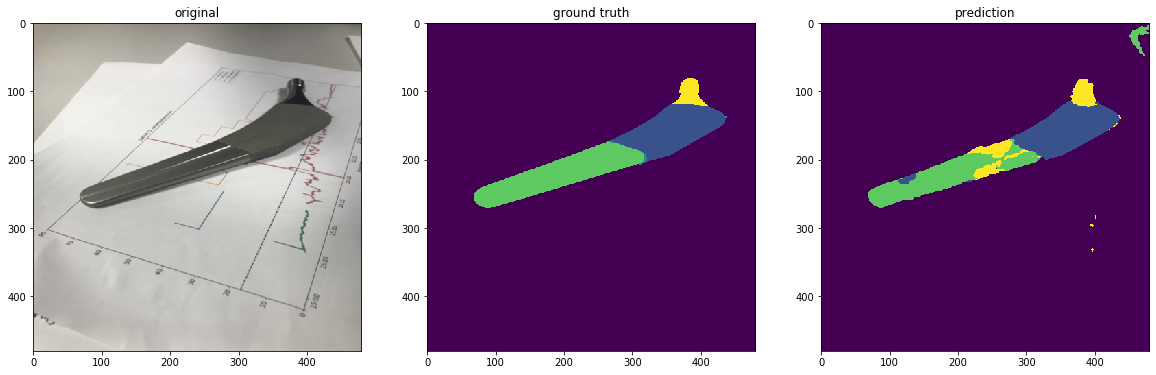

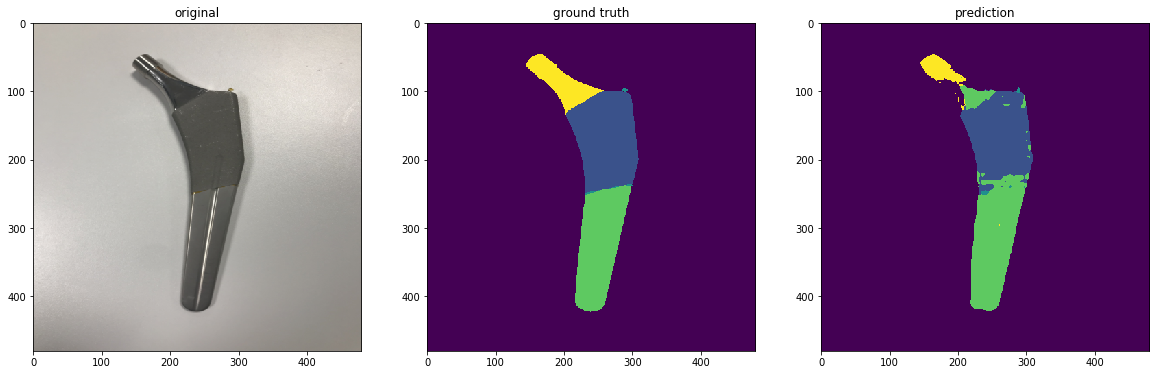

In [14]:
xzoom, yzoom = [(None, None), (None, None)], [(None, None), (None, None)]
titles = ['original', 'ground truth', 'prediction']
images = [X_test, combine(y_test), combine(y_pred)]

for i, _ in enumerate(X_test):
    plt.figure(figsize=(20, 10))
    for plot, (title, image) in enumerate(zip(titles, images)):
        plt.subplot(1, 3, plot+1)
        plt.imshow(image[i])
        plt.title(title)
        plt.xlim(xzoom[i]); plt.ylim(yzoom[i])

### Defect class only

Probability predictions for tape class


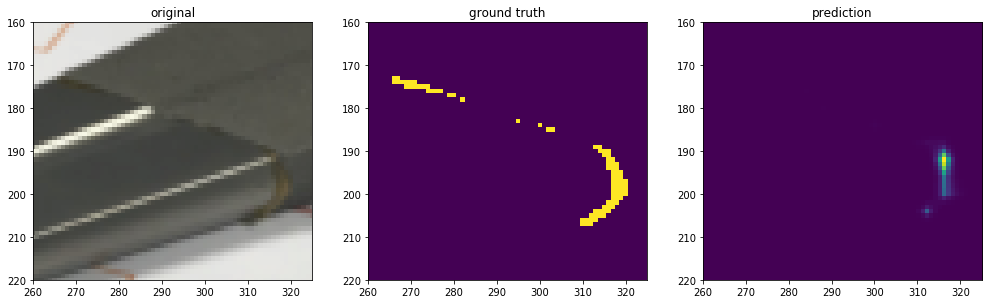

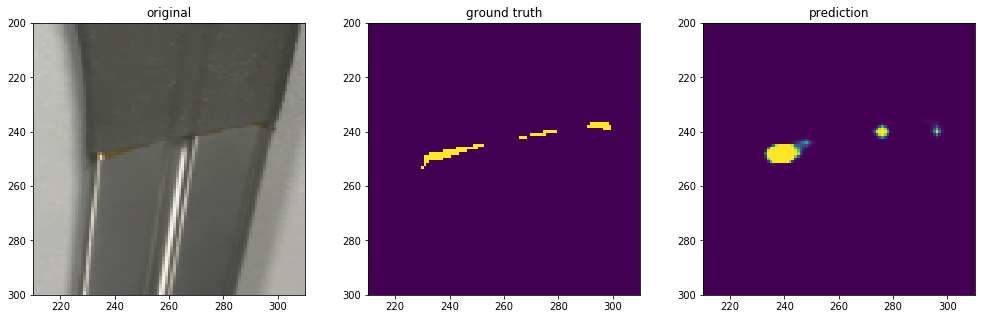

In [15]:
# Alter defect class and zooms as required
defect_class = 2
xzoom, yzoom = [(260, 325), (210, 310)], [(220, 160), (300, 200)]

titles = ['original', 'ground truth', 'prediction']
images = [X_test, y_test[:, :, :, defect_class], y_pred[:, :, :, defect_class]]

print(f'Probability predictions for {classes[defect_class]} class')

for i, _ in enumerate(X_test):
    plt.figure(figsize=(17, 5))
    for plot, (title, image) in enumerate(zip(titles, images)):
        plt.subplot(1, 3, plot+1)
        plt.imshow(image[i])
        plt.title(title)
        plt.xlim(xzoom[i]); plt.ylim(yzoom[i])

## Classification_Report
This should be run on a combined (single channel) image.

In [16]:
print(
    classification_report(
        combine(y_test).ravel(),
        combine(y_pred).ravel(),
        target_names=classes
    )
)

                  precision    recall  f1-score   support

      background       1.00      1.00      1.00    418217
  coated surface       0.97      0.92      0.94     18888
            tape       0.52      0.33      0.41       210
   blast surface       0.85      0.87      0.86     18924
polished surface       0.58      0.54      0.56      4561

        accuracy                           0.98    460800
       macro avg       0.78      0.73      0.75    460800
    weighted avg       0.98      0.98      0.98    460800



## ROC_curve

### On class specific channels
Below the roc curve is shown for each channel __when considered individualy__.  This is not representitive of a combined image.

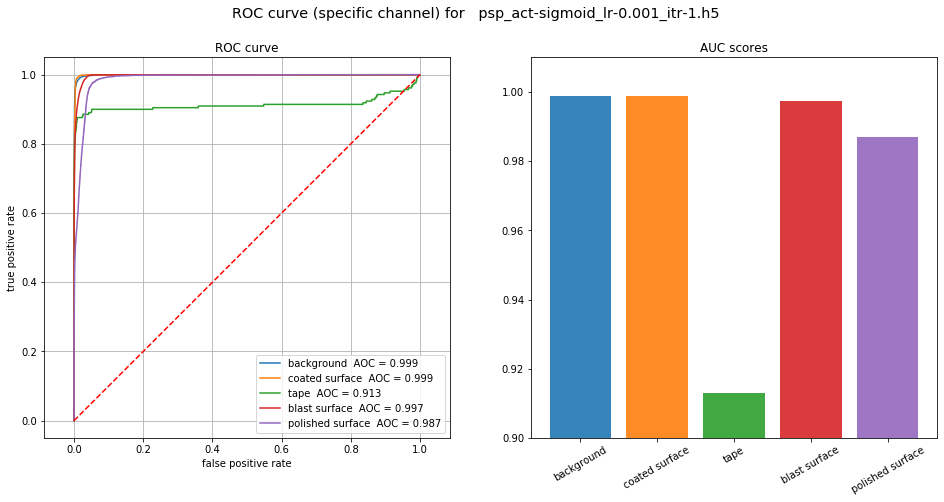

In [17]:
aocs = []

plt.figure(figsize=(16, 7))
plt.suptitle(f'ROC curve (specific channel) for   {model_path.split("/")[-1]}', size='x-large')

plt.subplot(121)
for cls, name in enumerate(classes):
    aoc = roc_auc_score( y_test[:, :, :, cls].ravel(), y_pred[:, :, :, cls].ravel() )
    aocs.append(aoc)
    fpr, tpr, thresholds = roc_curve( y_test[:, :, :, cls].ravel(), y_pred[:, :, :, cls].ravel() )
    plt.plot(fpr, tpr, label=f'{name}  AOC = {aoc:.3f}')
plt.plot([0, 1], [0, 1], ls='--', c='r')
plt.title(f'ROC curve')
plt.xlabel('false positive rate'); plt.ylabel('true positive rate')
plt.axis('equal')
plt.grid()
plt.legend(loc='lower right')

plt.subplot(122)
plt.bar(classes, aocs, color=plt.rcParams['axes.prop_cycle'].by_key()['color'], alpha=0.9)
plt.title('AUC scores')
plt.ylim(0.9, 1.01)
plt.xticks(rotation=30);

## Precision-Recall_curve

### On class specific channels
Below the precision-recall curve is shown for each channel __when considered individualy__.  This is not representitive of a combined image.

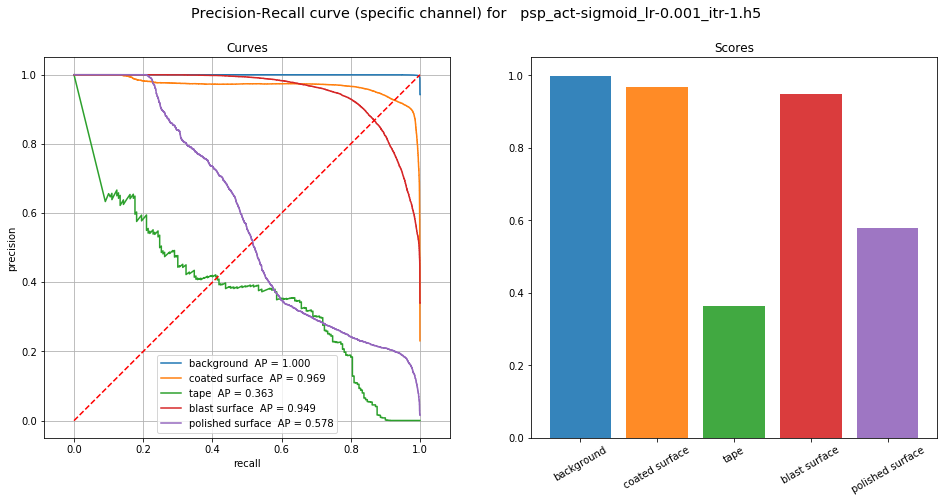

In [37]:
aps = []

plt.figure(figsize=(16, 7))
plt.suptitle(f'Precision-Recall curve (specific channel) for   {model_path.split("/")[-1]}', size='x-large')

plt.subplot(121)
for cls, name in enumerate(classes):
    ap = average_precision_score( y_test[:, :, :, cls].ravel(), y_pred[:, :, :, cls].ravel() )
    aps.append(ap)
    precision, recall, thresholds = precision_recall_curve( y_test[:, :, :, cls].ravel(), y_pred[:, :, :, cls].ravel() )
    plt.plot(recall, precision, label=f'{name}  AP = {ap:.3f}')
plt.plot([0, 1], [0, 1], ls='--', c='r')
plt.title(f'Curves')
plt.xlabel('recall'); plt.ylabel('precision')
plt.axis('equal')
plt.grid()
plt.legend(loc='lower center')

plt.subplot(122)
plt.bar(classes, aps, color=plt.rcParams['axes.prop_cycle'].by_key()['color'], alpha=0.9)
plt.title('Scores')
# plt.ylim(0.9, 1.01)
plt.xticks(rotation=30);

## On combined image
The roc curve below is for the binary recocnition of a defect class **from the combined image**.  Note this requires an advanced function to be used for combining which applied a threshold for identification of the defect class.

In [46]:
threshs = np.linspace(0, 1, 1000)


(combine_advanced(y_pred, 1, 0.1) == True) == combine(y_test)

0.9472829861111111